# Project description

I analyzed historical data on airport taxi orders to explore patterns and predict the number of taxi orders expected in the next hour. The goal was to create a predictive model that can help optimize driver availability during peak times, ensuring better service and increased efficiency.

## Project instructions

**1. Download and Prepare Data:**
* Loaded the dataset and parsed the datetime column.
* Resampled the data to hourly intervals using resample('1h').

**2. EDA**
* Visualized trends in the time series with hourly taxi orders.
* Analyzed the distribution of orders using histograms.
* Performed seasonal decomposition to explore trends, seasonality, and residuals.
* Printed summary statistics for trends, seasonality, and residuals.
* Analyze the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots to identify significant lags.



**3. Feature Engineering**
* Created lag features such as lag_1, lag_3, lag_5, lag_24, and lag_48 to capture short-term and daily dependencies.
* Added rolling mean and standard deviation features over 3-hour, 7-hour, 14-hour, 24-hour, and 48-hour windows.
* Engineered time-based features like hour, day_of_week, and is_weekend.
* Decomposed the data into trend, seasonal, and residual components.
* Addressed multicollinearity by removing highly correlated features using a correlation
* Used PolynomialFeatures with degree=2 to add squared terms and interactions for non-linear relationships.

**4. Model Training**
* Trained multiple models (Decision Tree, Random Forest, Linear Regression).
* Performed hyperparameter optimization using GridSearchCV for Decision Tree and Random Forest.
* Performed linear regression with polynomial features.


**5. Validation and Model Selection**
* Use TimeSeriesSplit (5 splits) to validate model performance on the training data.
* Perform hyperparameter tuning with GridSearchCV to find the optimal parameters for each model.
* Compare models (Decision Tree, Random Forest, Linear Regression with polynomial features) using Root Mean Squared Error (RMSE) as the evaluation metric.

**6. Testing and Performance Evaluation**
* Evaluate the Best Model on the Test Set
* Visualize Model Predictions
* Plot residuals (Actual - Predicted) for the best-performing models to check for systematic patterns.
* Plot histograms to analyze the distribution of errors.

**7. Conclusion and Recommendations**
* Model Performance
* Practical Recommendations
* Future Improvements 


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso



In [11]:
#Reading data in
data = pd.read_csv('taxi.csv', parse_dates=['datetime'])

#Looking at missing values
missing_values = data.isnull().sum()

#Looking at duplicated items
duplicate_times = data.duplicated(subset=['datetime']).sum()

#Setting time to every hour
data.set_index('datetime', inplace=True)
hourly_data = data.resample('1h').sum()

print(hourly_data.head())
print()
print("Total number of missing values: ", missing_values)
print()
print("Total number of duplicated times: ", duplicate_times)
print()
print(data.info())

                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43

Total number of missing values:  datetime      0
num_orders    0
dtype: int64

Total number of duplicated times:  0

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


## EDA

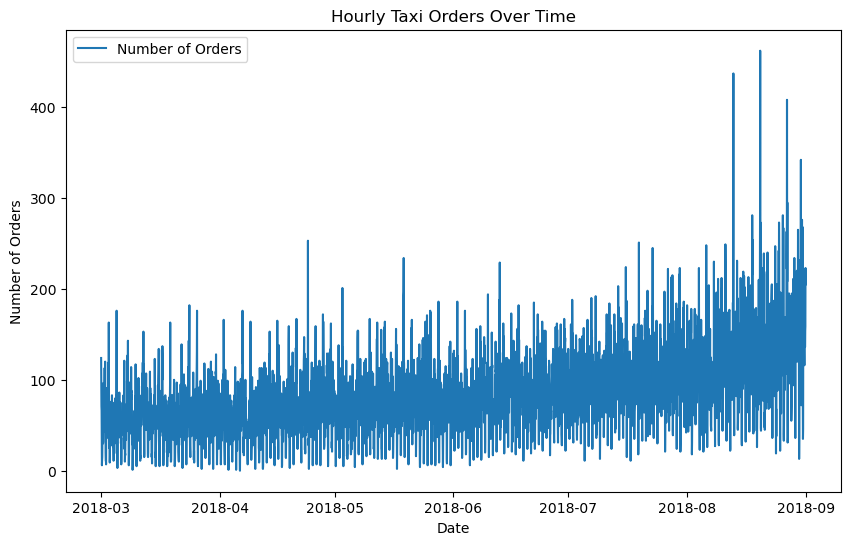

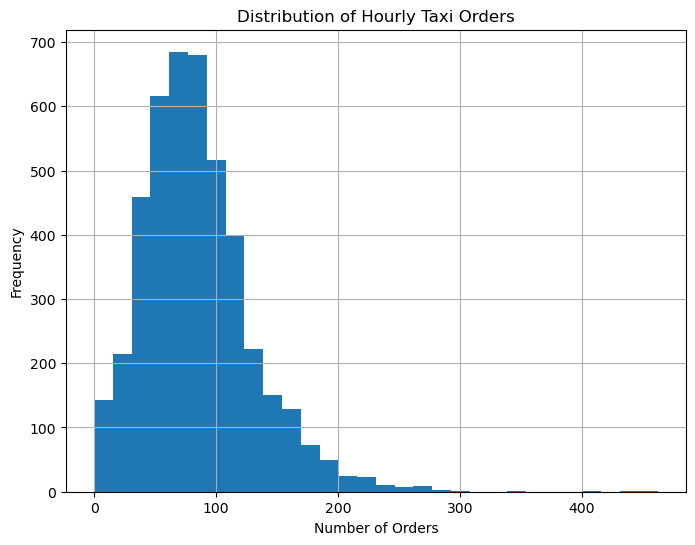

Summary Statistics for Number of Orders:
count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64


In [12]:
#Plot the time series of hourly taxi orders
plt.figure(figsize=(10, 6))
plt.plot(hourly_data.index, hourly_data['num_orders'], label='Number of Orders')
plt.title('Hourly Taxi Orders Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend()
plt.show()

#Check the distribution of the number of orders
plt.figure(figsize=(8, 6))
hourly_data['num_orders'].hist(bins=30)
plt.title('Distribution of Hourly Taxi Orders')
plt.xlabel('Number of Orders')
plt.ylabel('Frequency')
plt.show()

#Summary statistics for the number of orders
print("Summary Statistics for Number of Orders:")
print(hourly_data['num_orders'].describe())

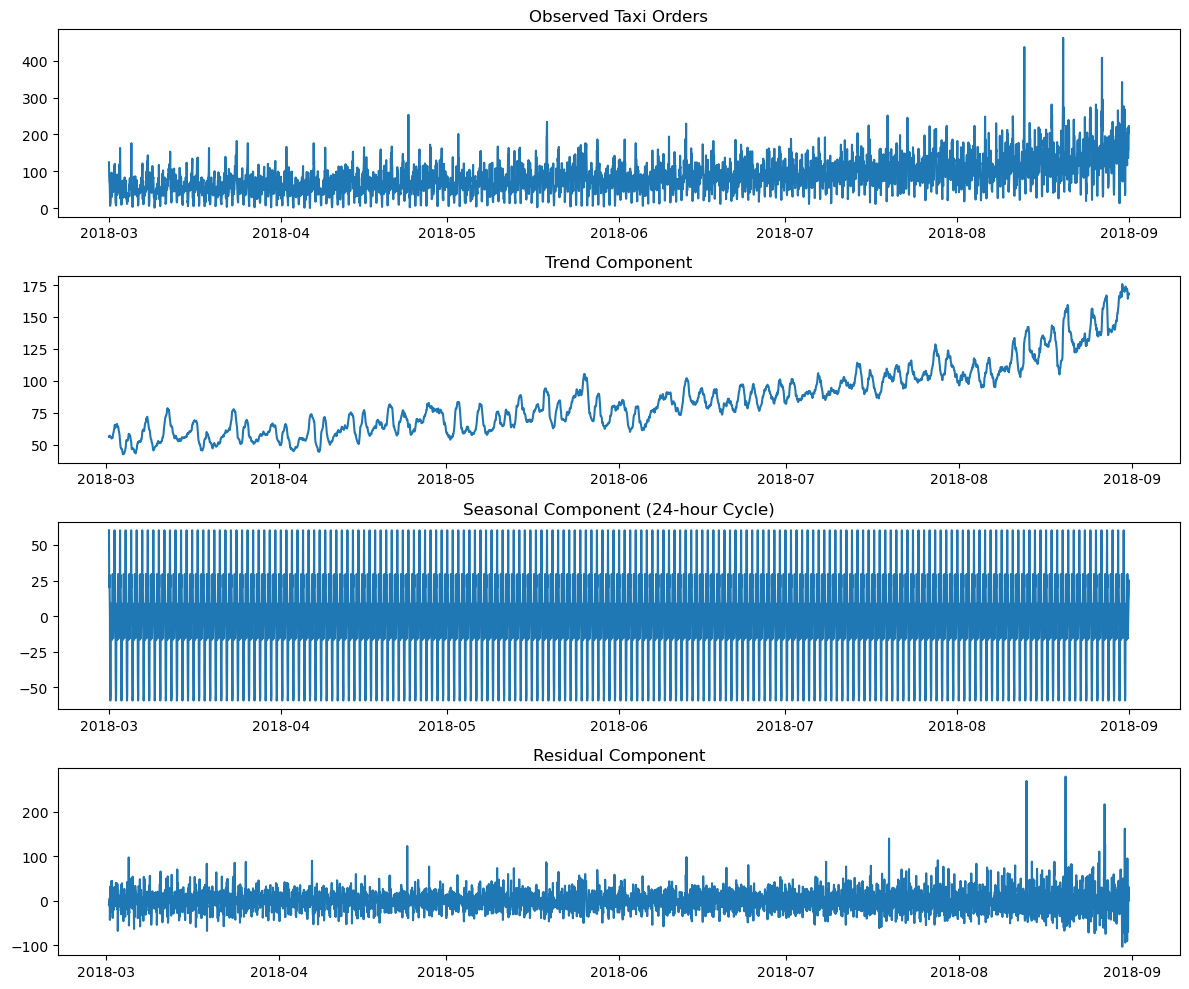

Decomposition Insights:
Trend:
count    4392.000000
mean       84.269742
std        26.311419
min        42.458333
25%        63.687500
50%        79.666667
75%        99.958333
max       175.729167
Name: trend, dtype: float64

Seasonality:
count    4.416000e+03
mean    -1.029772e-15
std      2.615659e+01
min     -5.918267e+01
25%     -1.174773e+01
50%      3.261489e+00
75%      1.466896e+01
max      6.024811e+01
Name: seasonal, dtype: float64

Residuals:
count    4392.000000
mean       -0.008130
std        24.696896
min      -103.546496
25%       -14.730950
50%        -1.387969
75%        12.967052
max       279.371423
Name: resid, dtype: float64


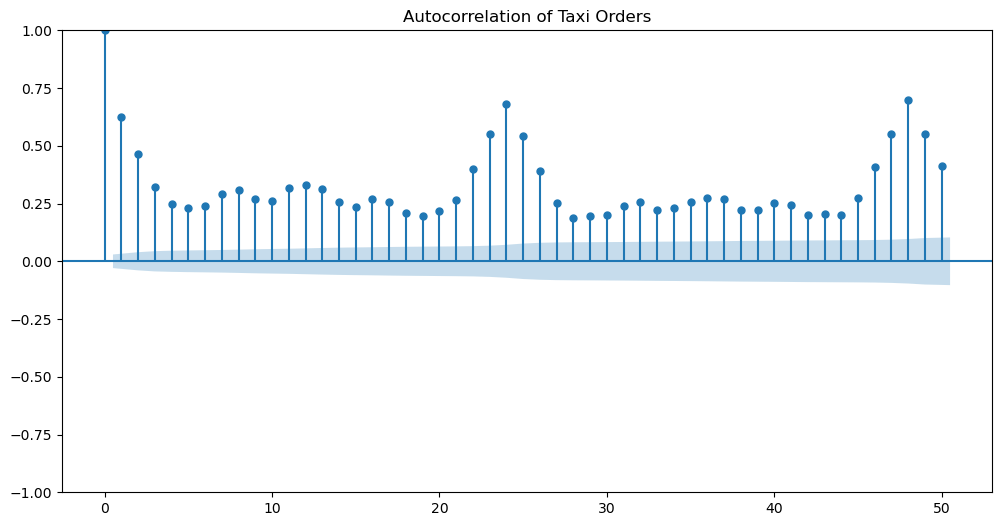

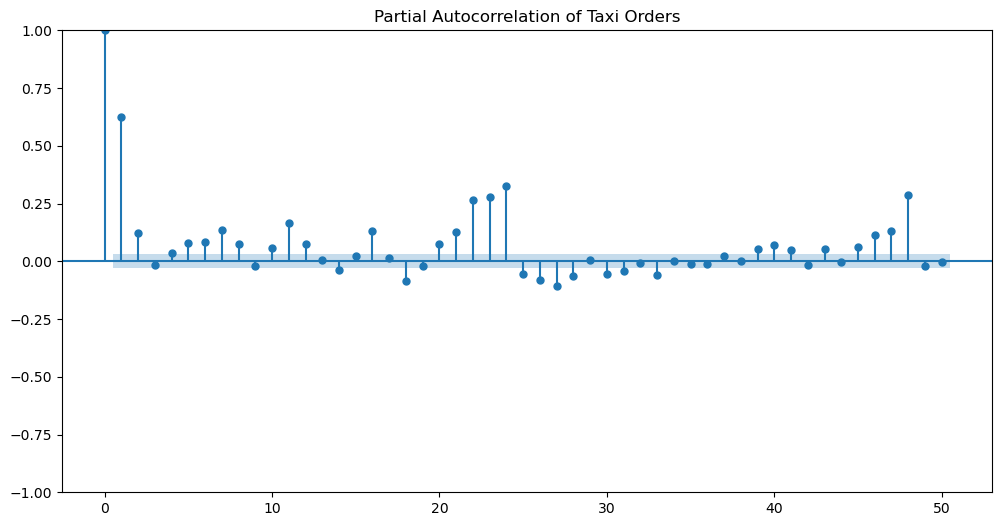

In [13]:
#Seasonal Decomposition of Time Series Data
decomposition = sm.tsa.seasonal_decompose(hourly_data['num_orders'], model='additive', period=24)

#Plot decomposed time series
plt.figure(figsize=(12, 10))

#Plotting observed data
plt.subplot(4, 1, 1)
plt.plot(decomposition.observed)
plt.title('Observed Taxi Orders')

#Plotting trend component
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend)
plt.title('Trend Component')

#Plotting seasonal component
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal)
plt.title('Seasonal Component (24-hour Cycle)')

#Plotting residual component
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid)
plt.title('Residual Component')

plt.tight_layout()
plt.show()

#Additional insights on trend, seasonality, and residuals
print("Decomposition Insights:")
print("Trend:")
print(decomposition.trend.dropna().describe())
print("\nSeasonality:")
print(decomposition.seasonal.dropna().describe())
print("\nResiduals:")
print(decomposition.resid.dropna().describe())



# Autocorrelation and Partial Autocorrelation Analysis
plt.figure(figsize=(12, 6))
plot_acf(hourly_data['num_orders'], lags=50, ax=plt.gca())
plt.title('Autocorrelation of Taxi Orders')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(hourly_data['num_orders'], lags=50, ax=plt.gca(), method='ywm')
plt.title('Partial Autocorrelation of Taxi Orders')
plt.show()

***Conclusion***

**Trend componet:**

The trend has an average of about 84 orders, meaning that's our baseline for hourly taxi demand across the dataset. The range, from around 42 to 176 orders, shows there are times when demand rises or drops pretty significantly. This points to an overall pattern of increasing or decreasing demand over time, which could be driven by outside factors like shifts in travel behavior or big events happening in the city.


**Seasonal component:**

The seasonal part has a mean close to zero, which makes sense since seasonality typically swings above and below the trend. With a standard deviation of about 26, it’s clear that seasonality has a big impact on hourly taxi orders. This component ranges from -59 to +60 orders, probably reflecting the usual daily peaks (like morning and evening rush hours) and lows (like late at night) that you’d expect in transportation data.


**Residual Component:**

The residuals have an average near zero but a pretty wide range, from -103 to +279 orders, showing a lot of unpredictable variation. This could be due to random events like local events, sudden weather changes, or other unexpected things that spike demand. The residual standard deviation around 24 means there’s a good amount of noise here, suggesting some factors affecting the data aren’t captured by just trend or seasonality.



**Autocorrelation (ACF) Plot:**

The autocorrelation plot shows a strong relationship at lag 1, indicating that the number of taxi orders in the previous hour heavily influences the current hour. Additionally, there are clear spikes at lags around 24 and 48, suggesting a strong daily seasonality (24-hour cycles) and a possible two-day pattern. The gradual decay of autocorrelation over longer lags highlights the presence of a long-term memory effect in the data. 

**Partial Autocorrelation (PACF) Plot:**

The partial autocorrelation plot reinforces these findings, with a significant spike at lag 1 and smaller but notable spikes at lag 24, confirming the influence of both short-term and daily trends. These insights suggest that incorporating lag 1 and lag 24 features, along with rolling averages over similar windows, can help the model better capture the underlying patterns in the data.

## Feature Engineering 

In [14]:
#Decompose the series into trend, seasonal, and residual
decomposition = seasonal_decompose(hourly_data['num_orders'], model='additive', period=24)
hourly_data['trend'] = decomposition.trend
hourly_data['seasonal'] = decomposition.seasonal
hourly_data['residual'] = decomposition.resid

# Create lag and rolling features
hourly_data['lag_1'] = hourly_data['num_orders'].shift(1)
hourly_data['lag_3'] = hourly_data['num_orders'].shift(3)
hourly_data['lag_5'] = hourly_data['num_orders'].shift(5)

# Add new lag features based on ACF and PACF analysis
hourly_data['lag_24'] = hourly_data['num_orders'].shift(24)  # Daily lag
hourly_data['lag_48'] = hourly_data['num_orders'].shift(48)  # Two-day lag

# Add rolling window features to capture trends over daily and two-day cycles
hourly_data['rolling_mean_24'] = hourly_data['num_orders'].shift(1).rolling(window=24).mean()
hourly_data['rolling_mean_48'] = hourly_data['num_orders'].shift(1).rolling(window=48).mean()
hourly_data['rolling_std_24'] = hourly_data['num_orders'].shift(1).rolling(window=24).std()

# Rolling means and exponential moving averages already in place
hourly_data['rolling_mean_3'] = hourly_data['num_orders'].shift(1).rolling(window=3).mean()
hourly_data['rolling_mean_7'] = hourly_data['num_orders'].shift(1).rolling(window=7).mean()
hourly_data['rolling_mean_14'] = hourly_data['num_orders'].shift(1).rolling(window=14).mean()
hourly_data['rolling_std_14'] = hourly_data['num_orders'].shift(1).rolling(window=14).std()
hourly_data['ema_7'] = hourly_data['num_orders'].shift(1).ewm(span=7, adjust=False).mean()

# Additional time-based features
hourly_data['hour'] = hourly_data.index.hour
hourly_data['day_of_week'] = hourly_data.index.dayofweek
hourly_data['is_weekend'] = (hourly_data['day_of_week'] >= 5).astype(int)


# Drop NaN values created by decomposition and feature engineering
hourly_data = hourly_data.dropna()

## Model Training

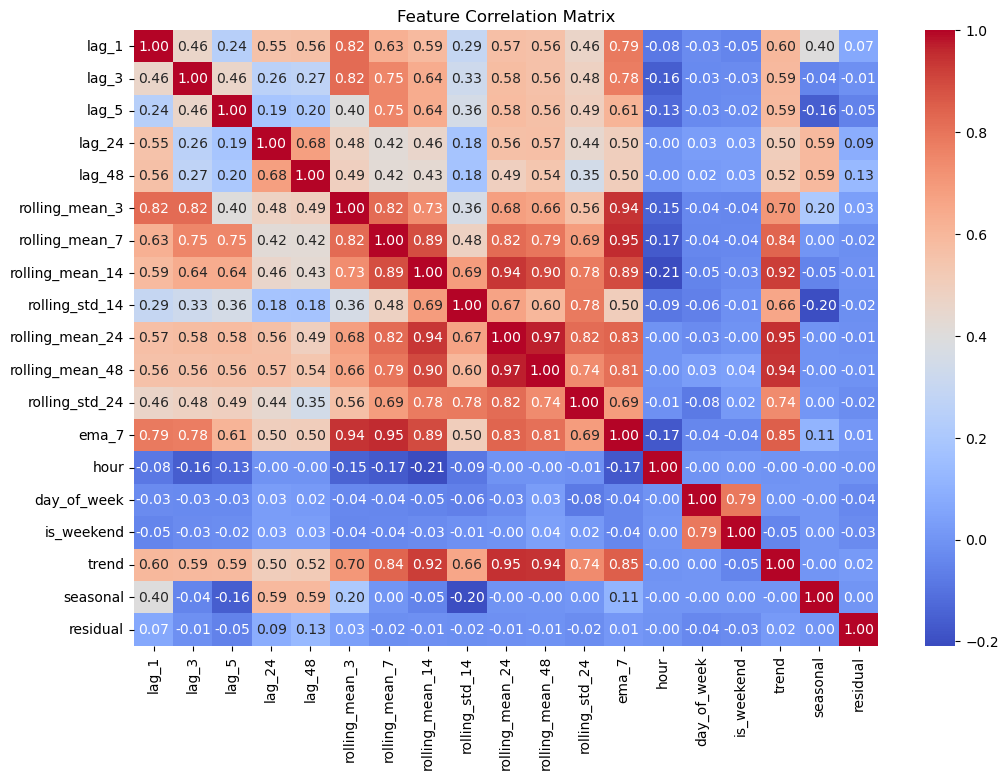

Dropped columns due to high correlation: ['rolling_mean_3', 'rolling_mean_7', 'rolling_mean_14', 'rolling_mean_24', 'rolling_mean_48', 'rolling_std_24', 'ema_7', 'is_weekend', 'trend']
Best parameters for Decision Tree: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best parameters for Random Forest: {'bootstrap': True, 'max_depth': 30, 'max_features': None, 'max_samples': 0.95, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 500}


In [15]:
# Features and target (including new lags and rolling features)
X = hourly_data[['lag_1', 'lag_3', 'lag_5', 'lag_24', 'lag_48', 
                 'rolling_mean_3', 'rolling_mean_7', 'rolling_mean_14', 
                 'rolling_std_14', 'rolling_mean_24', 'rolling_mean_48', 'rolling_std_24',
                 'ema_7', 'hour', 'day_of_week', 'is_weekend', 
                 'trend', 'seasonal', 'residual']]
y = hourly_data['num_orders']

#Correlation matrix to check multicollinearity
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

#Remove highly correlated features based on threshold
correlation_threshold = 0.7
corr_matrix = X.corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > correlation_threshold)]
X_reduced = X.drop(columns=to_drop)
print(f"Dropped columns due to high correlation: {to_drop}")


#Set up the TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)


param_grid_dt = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 10, 20, 30],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_rf_fine = {
    'n_estimators': [500],
    'max_depth': [30],
    'min_samples_split': [10],
    'min_samples_leaf': [3],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True],
    'max_samples': [0.95]            
}

#Initialize models
dt = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)

#GridSearch for Decision Tree with expanded hyperparameters
grid_dt = GridSearchCV(dt, param_grid_dt, cv=tscv, scoring='neg_root_mean_squared_error')
grid_dt.fit(X_reduced, y)
best_dt = grid_dt.best_estimator_

print("Best parameters for Decision Tree:", grid_dt.best_params_)

#GridSearch for Random Forest with expanded hyperparameters
grid_rf = GridSearchCV(rf, param_grid_rf_fine, cv=tscv, scoring='neg_root_mean_squared_error')
grid_rf.fit(X_reduced, y)
best_rf = grid_rf.best_estimator_

print("Best parameters for Random Forest:", grid_rf.best_params_)




## Validation and Model Selection

In [16]:
#Evaluate the best models and Linear Regression
models = {
    "Best Decision Tree": best_dt,
    "Best Random Forest": best_rf,
    "Linear Regression": LinearRegression()
}

poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(X_reduced)

# Define Lasso Regression with Hyperparameter Tuning
param_grid_lasso = {'alpha': [0.01, 0.1, 1, 10, 100]}  # Regularization strengths
lasso = Lasso(max_iter=5000)  # Increased max iterations for convergence


grid_lasso = GridSearchCV(lasso, param_grid_lasso, cv=tscv, scoring='neg_root_mean_squared_error')
grid_lasso.fit(X_poly, y)

# Best Lasso Model
best_lasso = grid_lasso.best_estimator_


# Keep only selected features
lasso_mask = best_lasso.coef_ != 0
X_selected = X_poly[:, lasso_mask]

print(f"Shape of X_selected after Lasso Feature Selection: {X_selected.shape}")

# Updated Train-Test Split with Selected Features
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.1, shuffle=False)


#Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, predictions)
    print(f'{name} RMSE with Seasonality and Trend Handling: {rmse}')

Shape of X_selected after Lasso Feature Selection: (4356, 59)
Best Decision Tree RMSE with Seasonality and Trend Handling: 46.224198564854575
Best Random Forest RMSE with Seasonality and Trend Handling: 31.31737940598054
Linear Regression RMSE with Seasonality and Trend Handling: 18.891148979379405


## Testing and Performance Evaluation

Final Model (Linear Regression) RMSE on the Test Set: 18.891148979379405


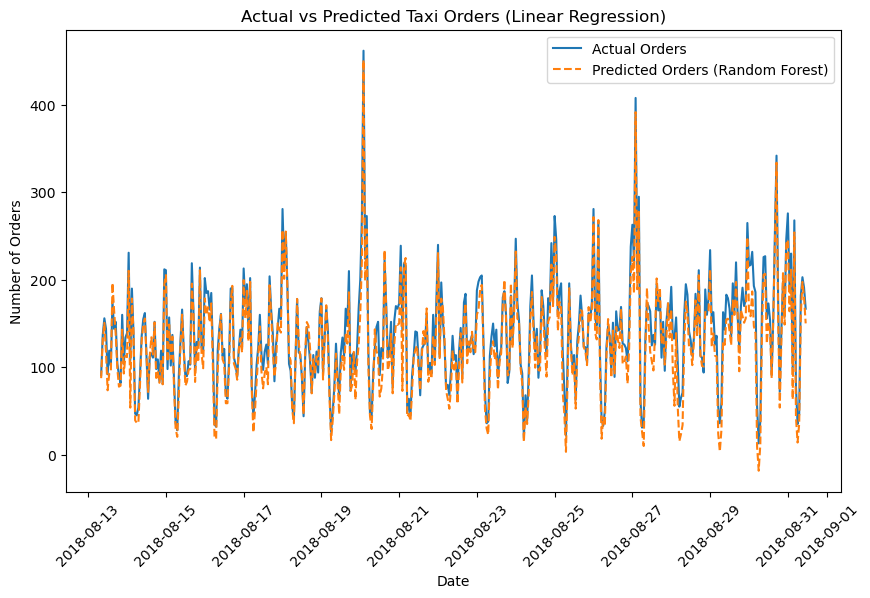

In [17]:
final_model = LinearRegression()
final_model.fit(X_train, y_train)
final_predictions = final_model.predict(X_test)

#Calculate RMSE for the final model
final_rmse = root_mean_squared_error(y_test, final_predictions)
print(f'Final Model (Linear Regression) RMSE on the Test Set: {final_rmse}')

#Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Orders')
plt.plot(y_test.index, final_predictions, label='Predicted Orders (Random Forest)', linestyle='--')
plt.title('Actual vs Predicted Taxi Orders (Linear Regression)')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45) 
plt.legend()
plt.show()

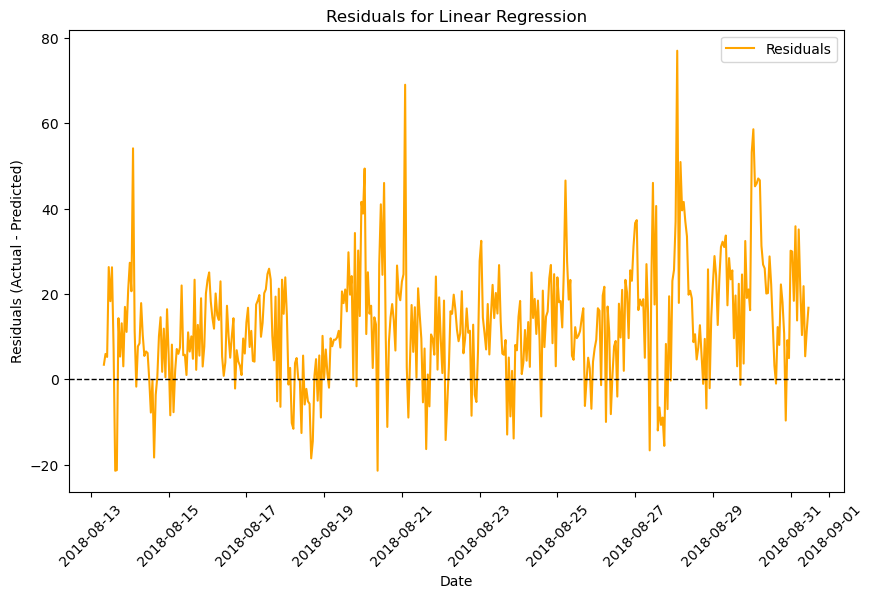


Residual Summary for Linear Regression:
count    436.000000
mean      12.774704
std       13.932972
min      -21.414988
25%        4.561731
50%       11.473716
75%       20.418187
max       77.028546
Name: num_orders, dtype: float64


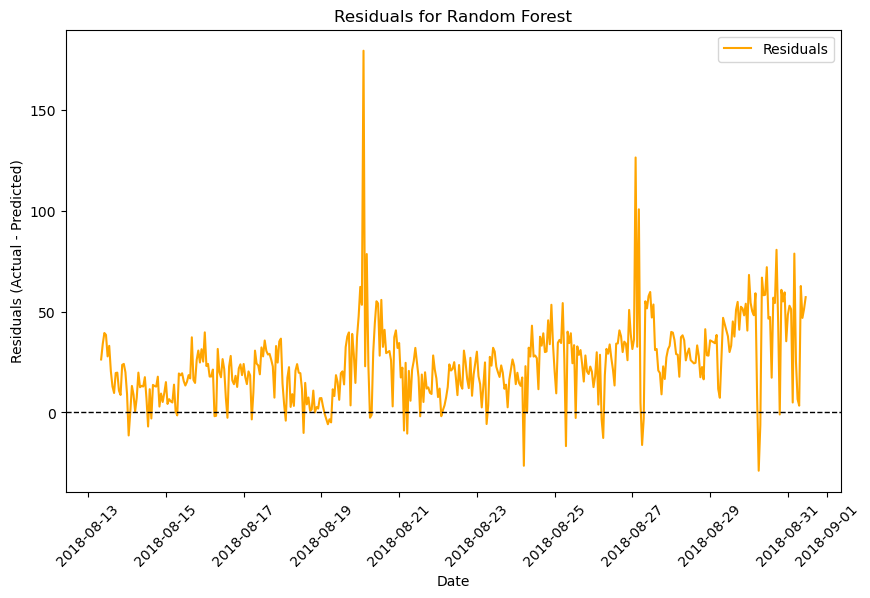


Residual Summary for Random Forest:
count    436.000000
mean      24.370639
std       19.691103
min      -28.887102
25%       12.651785
50%       22.993911
75%       33.583474
max      179.358394
Name: num_orders, dtype: float64


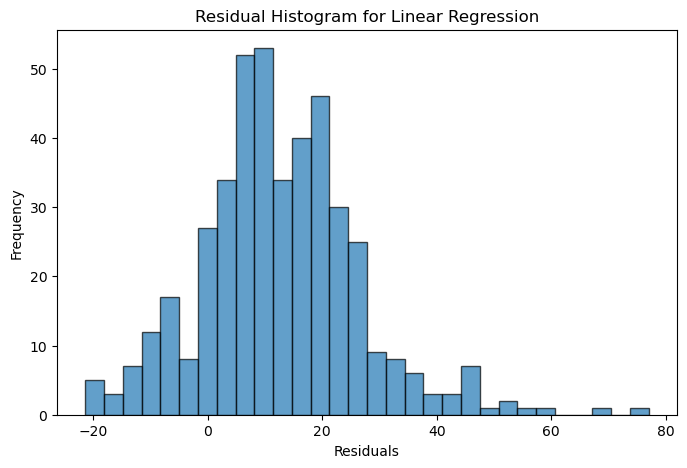

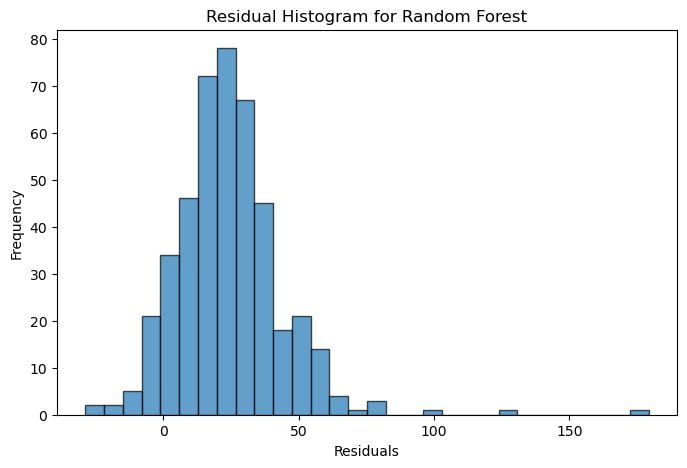

In [18]:
# Error Analysis: Residuals for Best Models
best_models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": best_rf
}

# Train and collect residuals
residuals = {}
for name, model in best_models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    residuals[name] = y_test - predictions  # Actual - Predicted
    
    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.index, residuals[name], label='Residuals', color='orange')
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.title(f'Residuals for {name}')
    plt.xlabel('Date')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()
    
    # Residual Summary
    print(f"\nResidual Summary for {name}:")
    print(residuals[name].describe())

# Plot Histogram of Residuals
for name in residuals:
    plt.figure(figsize=(8, 5))
    plt.hist(residuals[name], bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'Residual Histogram for {name}')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

***Error Analysis:***

**Linear Regression:** produces smaller and more consistent errors overall, making it a better model for general predictions in this case.

**Random Forest:** has better flexibility to capture complex patterns but struggles with extreme spikes in taxi orders, leading to larger residuals and outliers.


# Model Performance

In this project, we developed and tested multiple models to predict hourly taxi demand, focusing on seasonality, trends, and time-based dependencies. The models were evaluated using Root Mean Squared Error (RMSE) on unseen test data.


**Linear Regression with Polynomial Features:**

Achieved the best RMSE of 18.89, demonstrating its ability to capture linear and non-linear relationships effectively.
Lasso Regression (L1 regularization) further improved performance by reducing the polynomial features to the most relevant ones.

**Random Forest:**

RMSE: 31.31.
Despite strong performance, it struggled slightly after feature selection, as tree-based models typically benefit from a larger feature set.

**Decision Tree:**

RMSE: 46.22.
Performed the worst among all models due to its inability to generalize well with reduced features.



The Linear Regression model with Polynomial Features and Lasso-based feature selection outperformed the other models and is recommended as the primary model for deployment.

# Practical Recommendations

**Driver Scheduling Optimization:**

Use the Linear Regression model to identify peak demand hours and allocate more drivers during these periods.
Focus on improving driver availability during high-traffic times such as evenings and weekends.

**Operational Insights:**

Monitor the model predictions against real-time data to identify unexpected demand spikes and adjust operations accordingly.
Use historical demand patterns to inform driver incentives during predicted high-demand periods.

# Future Improvements

**Incorporate External Data:**

Add weather data, holidays, flight schedules, and special event calendars to improve prediction accuracy, especially during demand spikes.

**Explore Advanced Models:**

Implement deep learning models like LSTM (Long Short-Term Memory networks) or GRU to better capture long-term temporal dependencies.
Use tree-based ensemble models like XGBoost or LightGBM with optimized hyperparameters for better performance.

**Feature Engineering:**

Enhance lag features and rolling statistics with additional custom windows based on seasonal patterns (e.g., weekly or monthly lags).
Investigate Fourier transforms or wavelet transforms for improved seasonal signal extraction.

**Error Analysis:**

Analyze residuals further to identify specific time periods where the model underperforms (e.g., sudden demand spikes).
Incorporate a feedback loop to improve predictions based on identified outliers.